In [1]:
#Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.4. ML Visualizations/P1003.3.4.2. Decision Boundary Plot/Output')
cur_date = "092622"

library(readxl)
library(tidyverse)
library(tidycensus)
library(ggpubr)
library(quantreg)

# reading in files
acs_df = data.frame(read_excel("Input/ACS_Data_091422.xlsx", sheet = 2)) #R13168684_SL140.csv
wildfire_tract_df = data.frame(read_excel("Input/Wildfire_tract_053022.xls")) #WFH_tract_20220530.csv

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




In [2]:
# viewing data
head(acs_df)
head(wildfire_tract_df)

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,⋯,SE_A13001H_002,SE_A13001H_003,SE_A13001I_001,SE_A13001I_002,SE_A13001I_003,SE_A20001_001,SE_A20001_002,SE_A20001_003,SE_A20001_004,SE_A20001_005
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,37001020100,"Census Tract 201, Alamance County, North Carolina",ACSSF,nc,140,0,3490,NA,NA,NA,⋯,0,190,2638,370,2268,4048,439,3609,1755,2443
2,37001020200,"Census Tract 202, Alamance County, North Carolina",ACSSF,nc,140,0,3491,NA,NA,NA,⋯,693,985,1213,520,693,4021,755,3266,2035,1514
3,37001020301,"Census Tract 203.01, Alamance County, North Carolina",ACSSF,nc,140,0,3492,NA,NA,NA,⋯,286,1146,1064,444,620,3526,738,2788,1632,1708
4,37001020302,"Census Tract 203.02, Alamance County, North Carolina",ACSSF,nc,140,0,3493,NA,NA,NA,⋯,395,1781,774,121,653,3731,1081,2650,1757,1377
5,37001020400,"Census Tract 204, Alamance County, North Carolina",ACSSF,nc,140,0,3494,NA,NA,NA,⋯,242,981,1280,363,917,6634,1041,5593,3243,3046
6,37001020501,"Census Tract 205.01, Alamance County, North Carolina",ACSSF,nc,140,0,3495,NA,NA,NA,⋯,47,250,3097,345,2752,4063,541,3522,1294,2696


,OBJECTID,FID_1,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,⋯,Max_Wildfire.Hazard.Potential.Max,Var_Wildfire.Hazard.Potential.Max,SD_Wildfire.Hazard.Potential.Max,Avg_Wildfire.Hazard.Potential.Mean,Min_Wildfire.Hazard.Potential.Mean,Max_Wildfire.Hazard.Potential.Mean,Var_Wildfire.Hazard.Potential.Mean,SD_Wildfire.Hazard.Potential.Mean,Shape_Length,Shape_Area
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,37,141,920300,37141920300,9203,Census Tract 9203,G5020,S,⋯,6213,4735969.0,2176.22816,330.3177,116.8410,715.5177,111720.0965,334.24556,0.9949865,0.0232804652
2,2,1,37,141,990100,37141990100,9901,Census Tract 9901,G5020,S,⋯,6213,3086876.3,1756.95086,431.8320,157.4920,715.5177,77913.6727,279.13021,0.6011031,0.0130609691
3,3,2,37,071,031600,37071031600,316,Census Tract 316,G5020,S,⋯,840,264.5,16.26346,179.7338,171.3415,188.1261,140.8618,11.86852,0.2538232,0.0022595855
4,4,3,37,071,031800,37071031800,318,Census Tract 318,G5020,S,⋯,817,NA,NA,188.1261,188.1261,188.1261,NA,NA,0.1180164,0.0006021877
5,5,4,37,155,961801,37155961801,9618.01,Census Tract 9618.01,G5020,S,⋯,1484,NA,NA,229.8897,229.8897,229.8897,NA,NA,0.5870197,0.0102205805
6,6,5,37,155,961601,37155961601,9616.01,Census Tract 9616.01,G5020,S,⋯,2872,963272.0,981.46421,265.4323,229.8897,300.9749,2526.5545,50.26484,0.5817140,0.0077659405


Combining acs, wildifre tract, and census data to see if social determinants of health are associated with wildfire hazard potential.

In [3]:
# getting col names in the wildfire tract df that we're interested in 
wildfire_tract_df = wildfire_tract_df %>%
  select(GEOID, NAME, NAMELSAD, ALAND, AWATER, Avg_Wildfire.Hazard.Potential.Min, Min_Wildfire.Hazard.Potential.Max,
  Max_Wildfire.Hazard.Potential.Min, Avg_Wildfire.Hazard.Potential.Max, Min_Wildfire.Hazard.Potential.Max,
  Max_Wildfire.Hazard.Potential.Max, Avg_Wildfire.Hazard.Potential.Mean, Min_Wildfire.Hazard.Potential.Mean,
  Max_Wildfire.Hazard.Potential.Mean, Avg_ACRES, Min_ACRES, Max_ACRES) 

# renaming to create a FIPS col so we can merge the two dataframes
acs_df = acs_df %>%
  rename(GEOID = Geo_FIPS)

# merging the Wildfire data to ACS data
wildfire_tract_acs_df <- merge(wildfire_tract_df, acs_df, by = "GEOID")
head(wildfire_tract_acs_df)

,GEOID,NAME,NAMELSAD,ALAND,AWATER,Avg_Wildfire.Hazard.Potential.Min,Min_Wildfire.Hazard.Potential.Max,Max_Wildfire.Hazard.Potential.Min,Avg_Wildfire.Hazard.Potential.Max,Max_Wildfire.Hazard.Potential.Max,⋯,SE_A13001H_002,SE_A13001H_003,SE_A13001I_001,SE_A13001I_002,SE_A13001I_003,SE_A20001_001,SE_A20001_002,SE_A20001_003,SE_A20001_004,SE_A20001_005
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,37001020100,201,Census Tract 201,4511689,0,0,365,0,365,365,⋯,0,190,2638,370,2268,4048,439,3609,1755,2443
2,37001020200,202,Census Tract 202,3464706,0,0,365,0,365,365,⋯,693,985,1213,520,693,4021,755,3266,2035,1514
3,37001020301,203.01,Census Tract 203.01,4963841,62025,0,365,0,365,365,⋯,286,1146,1064,444,620,3526,738,2788,1632,1708
4,37001020302,203.02,Census Tract 203.02,6318866,141195,0,365,0,365,365,⋯,395,1781,774,121,653,3731,1081,2650,1757,1377
5,37001020400,204,Census Tract 204,11558153,268108,0,365,0,365,365,⋯,242,981,1280,363,917,6634,1041,5593,3243,3046
6,37001020501,205.01,Census Tract 205.01,7138142,78069,0,365,0,365,365,⋯,47,250,3097,345,2752,4063,541,3522,1294,2696


In [4]:
# pulling data from the census using an API key
# request your own API key at http://api.census.gov/data/key_signup.html 
census_api_key("26887b197b0785a54a045f3be1cd67622a569fb1", install = TRUE, overwrite = TRUE) 

# necessary to access data
readRenviron("~/.Renviron")

# obtaining data and feature geometry for the ACS
NC_income <- get_acs(
  geography = "tract", 
  variables = "B19013_001",
  state = "NC", 
  year = 2020,
  geometry = TRUE
)

head(NC_income)

Your original .Renviron will be backed up and stored in your R HOME directory if needed.

Your API key has been stored in your .Renviron and can be accessed by Sys.getenv("CENSUS_API_KEY"). 
To use now, restart R or run `readRenviron("~/.Renviron")`



[1] "26887b197b0785a54a045f3be1cd67622a569fb1"

Getting data from the 2016-2020 5-year ACS




  |======================================================================| 100%


ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called ‘geojsonio’

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_geojson.sf(obj)
8. repr_geojson(geo

,GEOID,NAME,variable,estimate,moe,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,37037020600,"Census Tract 206, Chatham County, North Carolina",B19013_001,51144,4786,MULTIPOLYGON (((-79.40216 3...
2,37153970200,"Census Tract 9702, Richmond County, North Carolina",B19013_001,49550,9719,MULTIPOLYGON (((-80.07567 3...
3,37001021702,"Census Tract 217.02, Alamance County, North Carolina",B19013_001,70807,11928,MULTIPOLYGON (((-79.52464 3...
4,37001020100,"Census Tract 201, Alamance County, North Carolina",B19013_001,36364,9774,MULTIPOLYGON (((-79.45802 3...
5,37063001711,"Census Tract 17.11, Durham County, North Carolina",B19013_001,42016,7874,MULTIPOLYGON (((-78.94294 3...
6,37063001002,"Census Tract 10.02, Durham County, North Carolina",B19013_001,26600,7448,MULTIPOLYGON (((-78.8807 35...


In [5]:
# creating a df that only contains feature geometry
NC_feature_geometry_df = NC_income %>%
    select(GEOID, geometry)

# merging geometry (extracted acs data) with the wildfire hazard and census data
wildfire_hazard_acs_geometry_df = merge(NC_feature_geometry_df, wildfire_tract_acs_df, by = "GEOID") %>%
    # the acs geometry data provides number of individuals, which will be converted into a percentage
    # SE_A00001_001 = total population column
    filter(SE_A00001_001 > 0) %>%
    # only keeping the census tract data
    select(-contains("Geo_"))

head(wildfire_hazard_acs_geometry_df)

ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called ‘geojsonio’

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_geojson.sf(obj)
8. repr_geojson(geo

GEOID       NAME   NAMELSAD            ALAND    AWATER
1 37001020100 201    Census Tract 201     4511689      0
2 37001020200 202    Census Tract 202     3464706      0
3 37001020301 203.01 Census Tract 203.01  4963841  62025
4 37001020302 203.02 Census Tract 203.02  6318866 141195
5 37001020400 204    Census Tract 204    11558153 268108
6 37001020501 205.01 Census Tract 205.01  7138142  78069
  Avg_Wildfire.Hazard.Potential.Min Min_Wildfire.Hazard.Potential.Max
1 0                                 365                              
2 0                                 365                              
3 0                                 365                              
4 0                                 365                              
5 0                                 365                              
6 0                                 365                              
  Max_Wildfire.Hazard.Potential.Min Avg_Wildfire.Hazard.Potential.Max
1 0                                 365                              
2 0                                 365                              
3 0                                 365                              
4 0                                 365                              
5 0                                 365                              
6 0                                 365                              
  Max_Wildfire.Hazard.Potential.Max geometry                       ⋯
1 365                               MULTIPOLYGON (((-79.45802 3... ⋯
2 365                               MULTIPOLYGON (((-79.43321 3... ⋯
3 365                               MULTIPOLYGON (((-79.41992 3... ⋯
4 365                               MULTIPOLYGON (((-79.40876 3... ⋯
5 365                               MULTIPOLYGON (((-79.46613 3... ⋯
6 365                               MULTIPOLYGON (((-79.49342 3... ⋯
  SE_A13001H_003 SE_A13001I_001 SE_A13001I_002 SE_A13001I_003 SE_A20001_001
1  190           2638           370            2268           4048         
2  985           1213           520             693           4021         
3 1146           1064           444             620           3526         
4 1781            774           121             653           3731         
5  981           1280           363             917           6634         
6  250           3097           345            2752           4063         
  SE_A20001_002 SE_A20001_003 SE_A20001_004 SE_A20001_005
1  439          3609          1755          2443         
2  755          3266          2035          1514         
3  738          2788          1632          1708         
4 1081          2650          1757          1377         
5 1041          5593          3243          3046         
6  541          3522          1294          2696         
  geometry                      
1 MULTIPOLYGON (((-79.45802 3...
2 MULTIPOLYGON (((-79.43321 3...
3 MULTIPOLYGON (((-79.41992 3...
4 MULTIPOLYGON (((-79.40876 3...
5 MULTIPOLYGON (((-79.46613 3...
6 MULTIPOLYGON (((-79.49342 3...

In [6]:
# before the some of the percentages can be calculated we need to obtain the total non-white and poverty populations
wildfire_hazard_acs_geometry_df$NonWhite <- (wildfire_hazard_acs_geometry_df$SE_A00001_001 - wildfire_hazard_acs_geometry_df$SE_B04001_003)
wildfire_hazard_acs_geometry_df$Poverty <- (wildfire_hazard_acs_geometry_df$SE_A13003A_002 + wildfire_hazard_acs_geometry_df$SE_A13003B_002 + wildfire_hazard_acs_geometry_df$SE_A13003C_002)

In [7]:
# it would be nice to make these lines more efficient , but that's not possible since the total population to calculqte each percentage are different for each column
# total population %  (further stratified by race, age)
wildfire_hazard_acs_geometry_df$Per_Black <- (wildfire_hazard_acs_geometry_df$SE_B04001_003 / wildfire_hazard_acs_geometry_df$SE_A00001_001) * 100
wildfire_hazard_acs_geometry_df$Per_NonWhite <- (wildfire_hazard_acs_geometry_df$NonWhite / wildfire_hazard_acs_geometry_df$SE_A00001_001) * 100
wildfire_hazard_acs_geometry_df$Per_White <- (wildfire_hazard_acs_geometry_df$SE_B04001_003 / wildfire_hazard_acs_geometry_df$SE_A00001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Native <- (wildfire_hazard_acs_geometry_df$SE_B04001_005 / wildfire_hazard_acs_geometry_df$SE_A00001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Asian <- (wildfire_hazard_acs_geometry_df$SE_B04001_006 / wildfire_hazard_acs_geometry_df$SE_A00001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Less5 <- (wildfire_hazard_acs_geometry_df$SE_A01001_002 / wildfire_hazard_acs_geometry_df$SE_A00001_001) * 100


# Poverty % (further stratified by race and age)
wildfire_hazard_acs_geometry_df$Per_Poverty <- (wildfire_hazard_acs_geometry_df$Poverty / wildfire_hazard_acs_geometry_df$SE_A00001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Poverty_NHWhite <- (wildfire_hazard_acs_geometry_df$SE_A13001I_002 / wildfire_hazard_acs_geometry_df$SE_A13001I_001) * 100
wildfire_hazard_acs_geometry_df$Per_Poverty_Black <- (wildfire_hazard_acs_geometry_df$SE_A13001B_002 / wildfire_hazard_acs_geometry_df$SE_A13001B_001) * 100
# some of the native american and asian rows have zeros, due to having a population of zero (0  denominator = undefined or NaN values)
wildfire_hazard_acs_geometry_df$Per_Poverty_Native <- (wildfire_hazard_acs_geometry_df$SE_A13001C_002 / wildfire_hazard_acs_geometry_df$SE_A13001C_001) * 100
wildfire_hazard_acs_geometry_df$Per_Poverty_Asian <- (wildfire_hazard_acs_geometry_df$SE_A13001D_002 / wildfire_hazard_acs_geometry_df$SE_A13001D_001) * 100
wildfire_hazard_acs_geometry_df$Per_Poverty_Hisp <- (wildfire_hazard_acs_geometry_df$SE_A13001H_002 / wildfire_hazard_acs_geometry_df$SE_A13001H_001) * 100
wildfire_hazard_acs_geometry_df$Per_Poverty_White <- (wildfire_hazard_acs_geometry_df$SE_A13001A_002 / wildfire_hazard_acs_geometry_df$SE_A13001A_001) * 100

wildfire_hazard_acs_geometry_df$Per_Poverty_Children <- (wildfire_hazard_acs_geometry_df$SE_A13003A_002 / (wildfire_hazard_acs_geometry_df$SE_A01001_002 + wildfire_hazard_acs_geometry_df$SE_A01001_003 + wildfire_hazard_acs_geometry_df$SE_A01001_004 + wildfire_hazard_acs_geometry_df$SE_A01001_005)) * 100
wildfire_hazard_acs_geometry_df$Per_Poverty_Adults <- (wildfire_hazard_acs_geometry_df$SE_A13001A_002 / (wildfire_hazard_acs_geometry_df$SE_A01001_006 + wildfire_hazard_acs_geometry_df$SE_A01001_007 + wildfire_hazard_acs_geometry_df$SE_A01001_008 + wildfire_hazard_acs_geometry_df$SE_A01001_009 + wildfire_hazard_acs_geometry_df$SE_A01001_010)) * 100
wildfire_hazard_acs_geometry_df$Per_Poverty_Seniors <- (wildfire_hazard_acs_geometry_df$SE_A13003C_002 / (wildfire_hazard_acs_geometry_df$SE_A01001_011 + wildfire_hazard_acs_geometry_df$SE_A01001_012 + wildfire_hazard_acs_geometry_df$SE_A01001_013)) * 100


# education level % 
wildfire_hazard_acs_geometry_df$Per_LHS_Edu <- (wildfire_hazard_acs_geometry_df$SE_A12001_002 / wildfire_hazard_acs_geometry_df$SE_A12001_001) * 100
wildfire_hazard_acs_geometry_df$Per_HS_Edu <- (wildfire_hazard_acs_geometry_df$SE_A12001_003 / wildfire_hazard_acs_geometry_df$SE_A12001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Some_College_Edu <- (wildfire_hazard_acs_geometry_df$SE_A12001_004 / wildfire_hazard_acs_geometry_df$SE_A12001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Bacehlors_Edu <- (wildfire_hazard_acs_geometry_df$SE_A12001_005 / wildfire_hazard_acs_geometry_df$SE_A12001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Masters_Edu <- (wildfire_hazard_acs_geometry_df$SE_A12001_006 / wildfire_hazard_acs_geometry_df$SE_A12001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Professional_Edu <- (wildfire_hazard_acs_geometry_df$SE_A12001_007 / wildfire_hazard_acs_geometry_df$SE_A12001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Doctorate_Edu <- (wildfire_hazard_acs_geometry_df$SE_A12001_008 / wildfire_hazard_acs_geometry_df$SE_A12001_001) * 100
wildfire_hazard_acs_geometry_df$Per_At_Least_College_Edu <- (wildfire_hazard_acs_geometry_df$SE_B12001_004 / wildfire_hazard_acs_geometry_df$SE_A12001_001) * 100


# insurance status % (further stratified by race)
wildfire_hazard_acs_geometry_df$Per_No_Ins <- (wildfire_hazard_acs_geometry_df$SE_A20001_002 / wildfire_hazard_acs_geometry_df$SE_A20001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Ins <- (wildfire_hazard_acs_geometry_df$SE_A20001_003 / wildfire_hazard_acs_geometry_df$SE_A20001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Public_Ins <- (wildfire_hazard_acs_geometry_df$SE_A20001_004 / wildfire_hazard_acs_geometry_df$SE_A20001_001) * 100
wildfire_hazard_acs_geometry_df$Per_Private_Ins <- (wildfire_hazard_acs_geometry_df$SE_A20001_005 / wildfire_hazard_acs_geometry_df$SE_A20001_001) * 100

In [8]:
# EXPORT THE wildfire_hazard_acs_geometry_df HERE

Determining if each socioeconomic status (SES) variable is associated with avg wildfire hazard potential mean using linear and quantile linear regression

In [9]:
# getting the poverty col names to iterate through them using a loop in the function below
poverty_variables = colnames(wildfire_hazard_acs_geometry_df)[112:121]

# creating the linear regression function 
linear_regression = function (df, SES_variables){
  # """
  # Creating a function to perform linear regression.
  # :param (input): df (containing data to be analyzed), socioeconomic status (SES variables)
  # :output: df containing the model/method, SES variable, statistic, p value, and p adjust
  # """
  
  # creating an empty df to store the t and p values from the linear regression
  values_df = data.frame()
  for (i in 1:length(SES_variables)){
    # generalized linear model (GLM)
    linear_model = glm(as.formula(paste0("Avg_Wildfire.Hazard.Potential.Mean", "~", SES_variables[i])), data = df, family = gaussian)
    summarized_linear_model = summary(linear_model)
    
    # creating a row of data that specifies the method, variable, statistic, and p value
    linear_values = c("Linear Regression", SES_variables[i], summarized_linear_model$coefficients[c(6,8)])
    
    # adding just the name statistic and p value to the df
    values_df = rbind(values_df, linear_values)
    
  }  
  
  # adding colnames
  colnames(values_df) = c("Method", "Variable", "Statistic", "P Value")
  
  # adjusting p value
  values_df$`P Adj` = p.adjust(as.numeric(as.character(values_df$`P Value`)), method = "fdr")
  
  return(values_df)
}

In [10]:
# calling function
lm_results = linear_regression(wildfire_hazard_acs_geometry_df, poverty_variables)
head(lm_results)

,Method,Variable,Statistic,P Value,P Adj
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,Linear Regression,Per_Poverty,1.43703846308728,0.150825297251181,0.3770632
2,Linear Regression,Per_Poverty_NHWhite,0.167609855770668,0.86690306453312,0.8669031
3,Linear Regression,Per_Poverty_Black,0.671006326192784,0.502278413076752,0.7882330
4,Linear Regression,Per_Poverty_Native,0.406869894033074,0.684179194962114,0.7882330
5,Linear Regression,Per_Poverty_Asian,-0.372708686344048,0.709409743967908,0.7882330
6,Linear Regression,Per_Poverty_Hisp,-0.456760786768936,0.647882423465659,0.7882330


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 143 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 143 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1495 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1495 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 870 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 870 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 130 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 130 rows containing missing values (ge

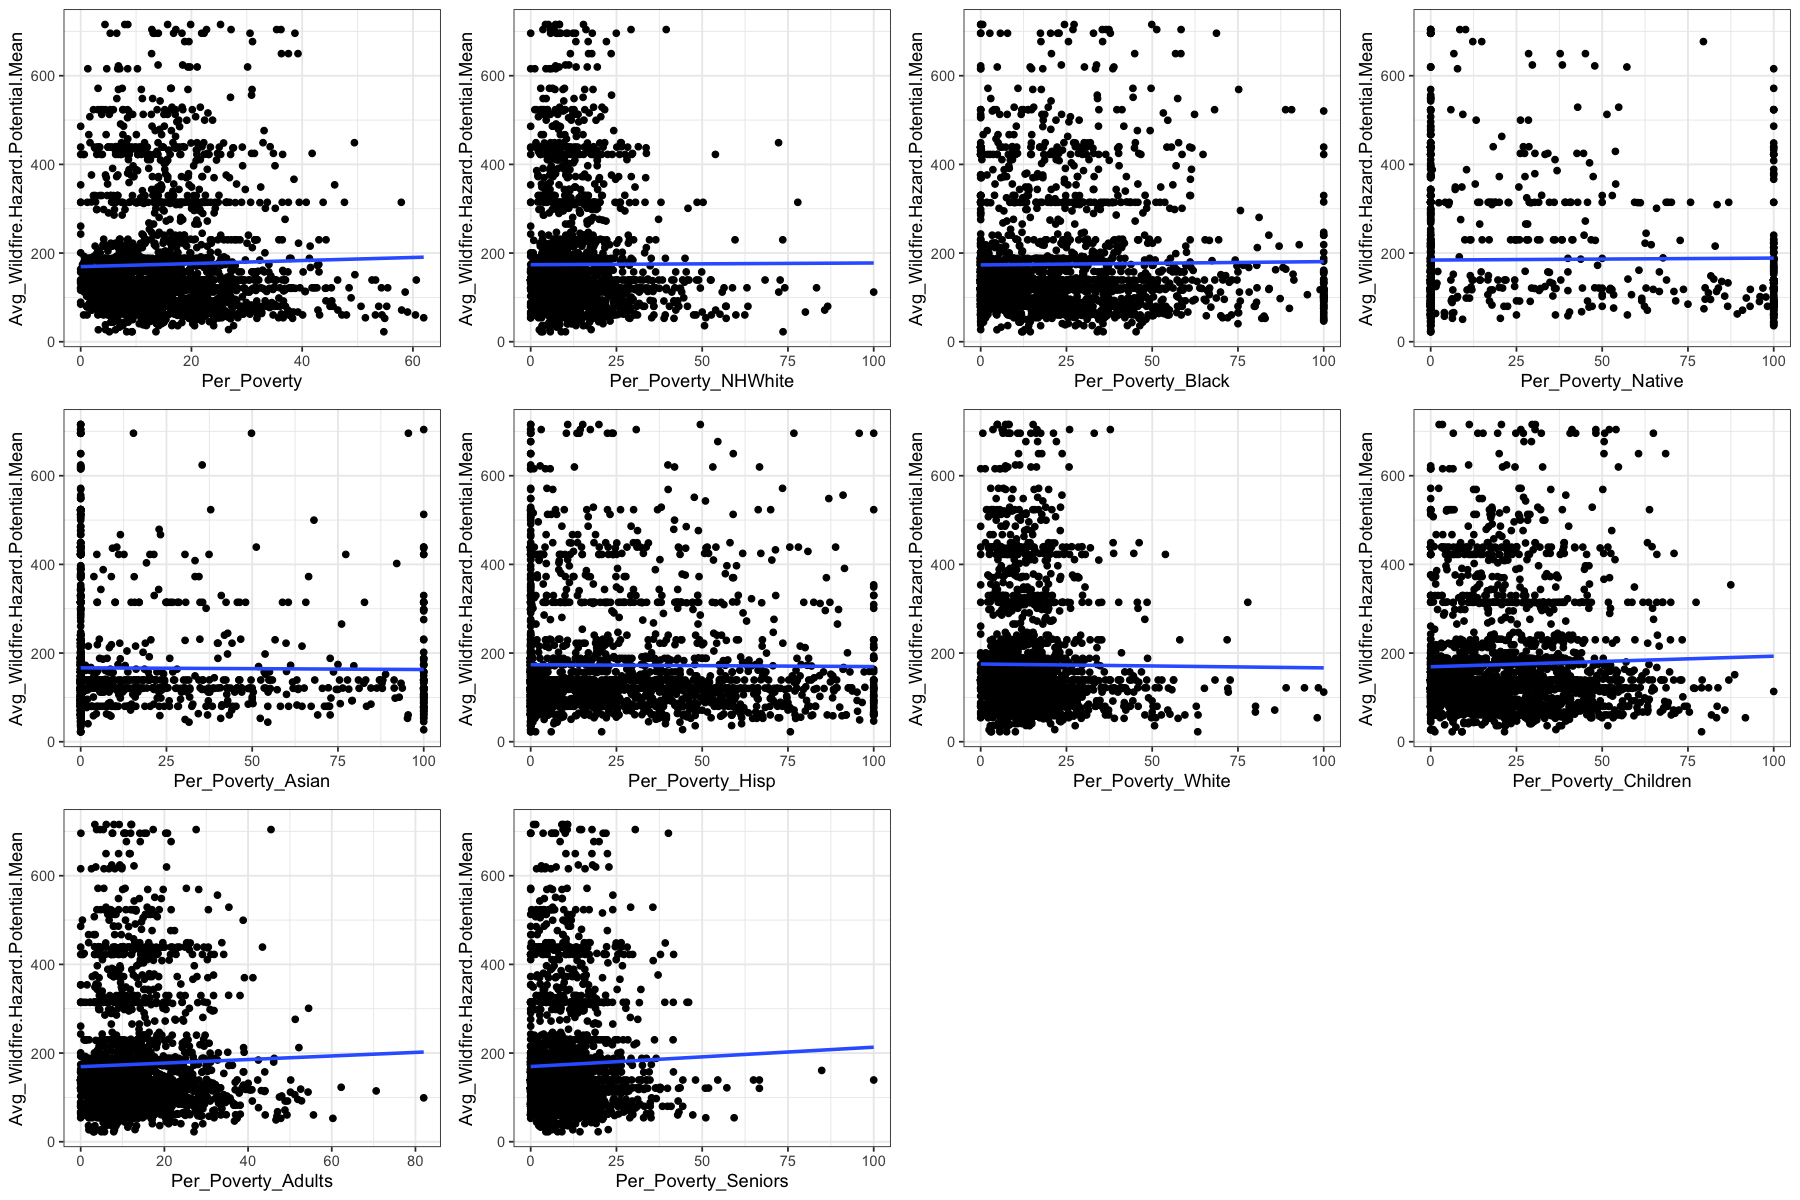

In [11]:
# creating linear plots
options(repr.plot.width=15, repr.plot.height=10) #changing plot size

plots = list()
for (i in 1:length(poverty_variables)){
  plots[[i]] = ggplot(data = wildfire_hazard_acs_geometry_df, 
                      mapping = aes_string(x = poverty_variables[i], y = "Avg_Wildfire.Hazard.Potential.Mean")) + 
    geom_point() + 
    geom_smooth(method = "lm", se = FALSE) + 
    theme_bw()
}

# viewing all plots
ggarrange(plotlist = plots)

Wildfire hazard potential (WHP) already seems to be grouping in strata, so quantile regression performs linear regression within each quantile.

Quantile regression is often used when the conditions of linear regression aren't met and estimates the conditional *median* (or other quantiles) of the response variable (WHP), while linear regression estimates the conditional *mean*. 

In [12]:
# creating the quantile regression function 
quantile_regression = function (df, SES_variables){
  # """
  # Creating a function to perform linear quantile regression.
  # :param (input): df (containing data to be analyzed), socioeconomic status (SES variables)
  # :output: df containing the model/method, SES variable, quantile, statistic, p value, and p adjust
  # """
  
  # creating a vector to loop through for the argument tau that specifies the quantile
  # for some reason having tau = 1 throws an error, so I used 0.99
  tau_values = c(0.2, 0.4, 0.6, 0.8, 0.99)
  
  # creating an empty df to store the t and p values from the quantile regression
  values_df = data.frame()
  
  for (i in 1:length(SES_variables)){
    for (j in 1:length(tau_values)){
      # quantile linear regression
      quantile_model = rq(as.formula(paste0("Avg_Wildfire.Hazard.Potential.Mean", "~", SES_variables[i])), 
                          data = df, tau = tau_values[j])
      summarized_quantile_model = summary(quantile_model)
      
      # creating a row of data that specifies the method, variable, tau, statistic, and p value
      quantile_values = c("Quantile Regression", SES_variables[i], tau_values[j], 
                          summarized_quantile_model$coefficients[c(6,8)])
      
      # adding just the name statistic and p value to the df
      values_df = rbind(values_df, quantile_values)
      
      }  
    }
  
  # adding colnames
  colnames(values_df) = c("Method", "Variable", "Quantile", "Statistic", "P Value")
  
  # adjusting p value within each quantile
  values_df = values_df %>%
    group_by(Quantile) %>%
    mutate(`P Adjust` = p.adjust(as.numeric(as.character(`P Value`)), method = "fdr")) %>%
    ungroup()
  
  return(values_df)
}

In [13]:
# calling function
quantile_results = quantile_regression(wildfire_hazard_acs_geometry_df, poverty_variables)
head(quantile_results)

Warning message in summary.rq(quantile_model):
“82 non-positive fis”
Warning message in summary.rq(quantile_model):
“4 non-positive fis”
Warning message in summary.rq(quantile_model):
“98 non-positive fis”
Warning message in summary.rq(quantile_model):
“3 non-positive fis”
Warning message in summary.rq(quantile_model):
“138 non-positive fis”
Warning message in summary.rq(quantile_model):
“31 non-positive fis”
Warning message in summary.rq(quantile_model):
“91 non-positive fis”
Warning message in summary.rq(quantile_model):
“5 non-positive fis”
Warning message in summary.rq(quantile_model):
“33 non-positive fis”


Method,Variable,Quantile,Statistic,P Value,P Adjust
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Quantile Regression,Per_Poverty,0.2,-10.2532970727577,0,0.0000000000
Quantile Regression,Per_Poverty,0.4,-0.577906396175726,0.563376491972601,0.8437726296
Quantile Regression,Per_Poverty,0.6,8.34274845197971e-15,0.999999999999993,1.0000000000
Quantile Regression,Per_Poverty,0.8,3.94957994927382,8.03328299485706e-05,0.0004016641
Quantile Regression,Per_Poverty,0.99,2.56950640609959,0.0102386600062292,0.0341288667
Quantile Regression,Per_Poverty_NHWhite,0.2,-12.0938797182803,0,0.0000000000


Smoothing formula not specified. Using: y ~ x

Warning message:
“Removed 8 rows containing non-finite values (stat_quantile).”
Smoothing formula not specified. Using: y ~ x

Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 143 rows containing non-finite values (stat_quantile).”
Smoothing formula not specified. Using: y ~ x

Warning message:
“Removed 143 rows containing missing values (geom_point).”
Warning message:
“Removed 1495 rows containing non-finite values (stat_quantile).”
Smoothing formula not specified. Using: y ~ x

Warning message:
“Removed 1495 rows containing missing values (geom_point).”
Warning message:
“Removed 870 rows containing non-finite values (stat_quantile).”
Smoothing formula not specified. Using: y ~ x

Warning message:
“Removed 870 rows containing missing values (geom_point).”
Warning message:
“Removed 130 rows containing non-finite values (stat_quantile).”
Smoothing formula not specified. Using: y ~ x

Warnin

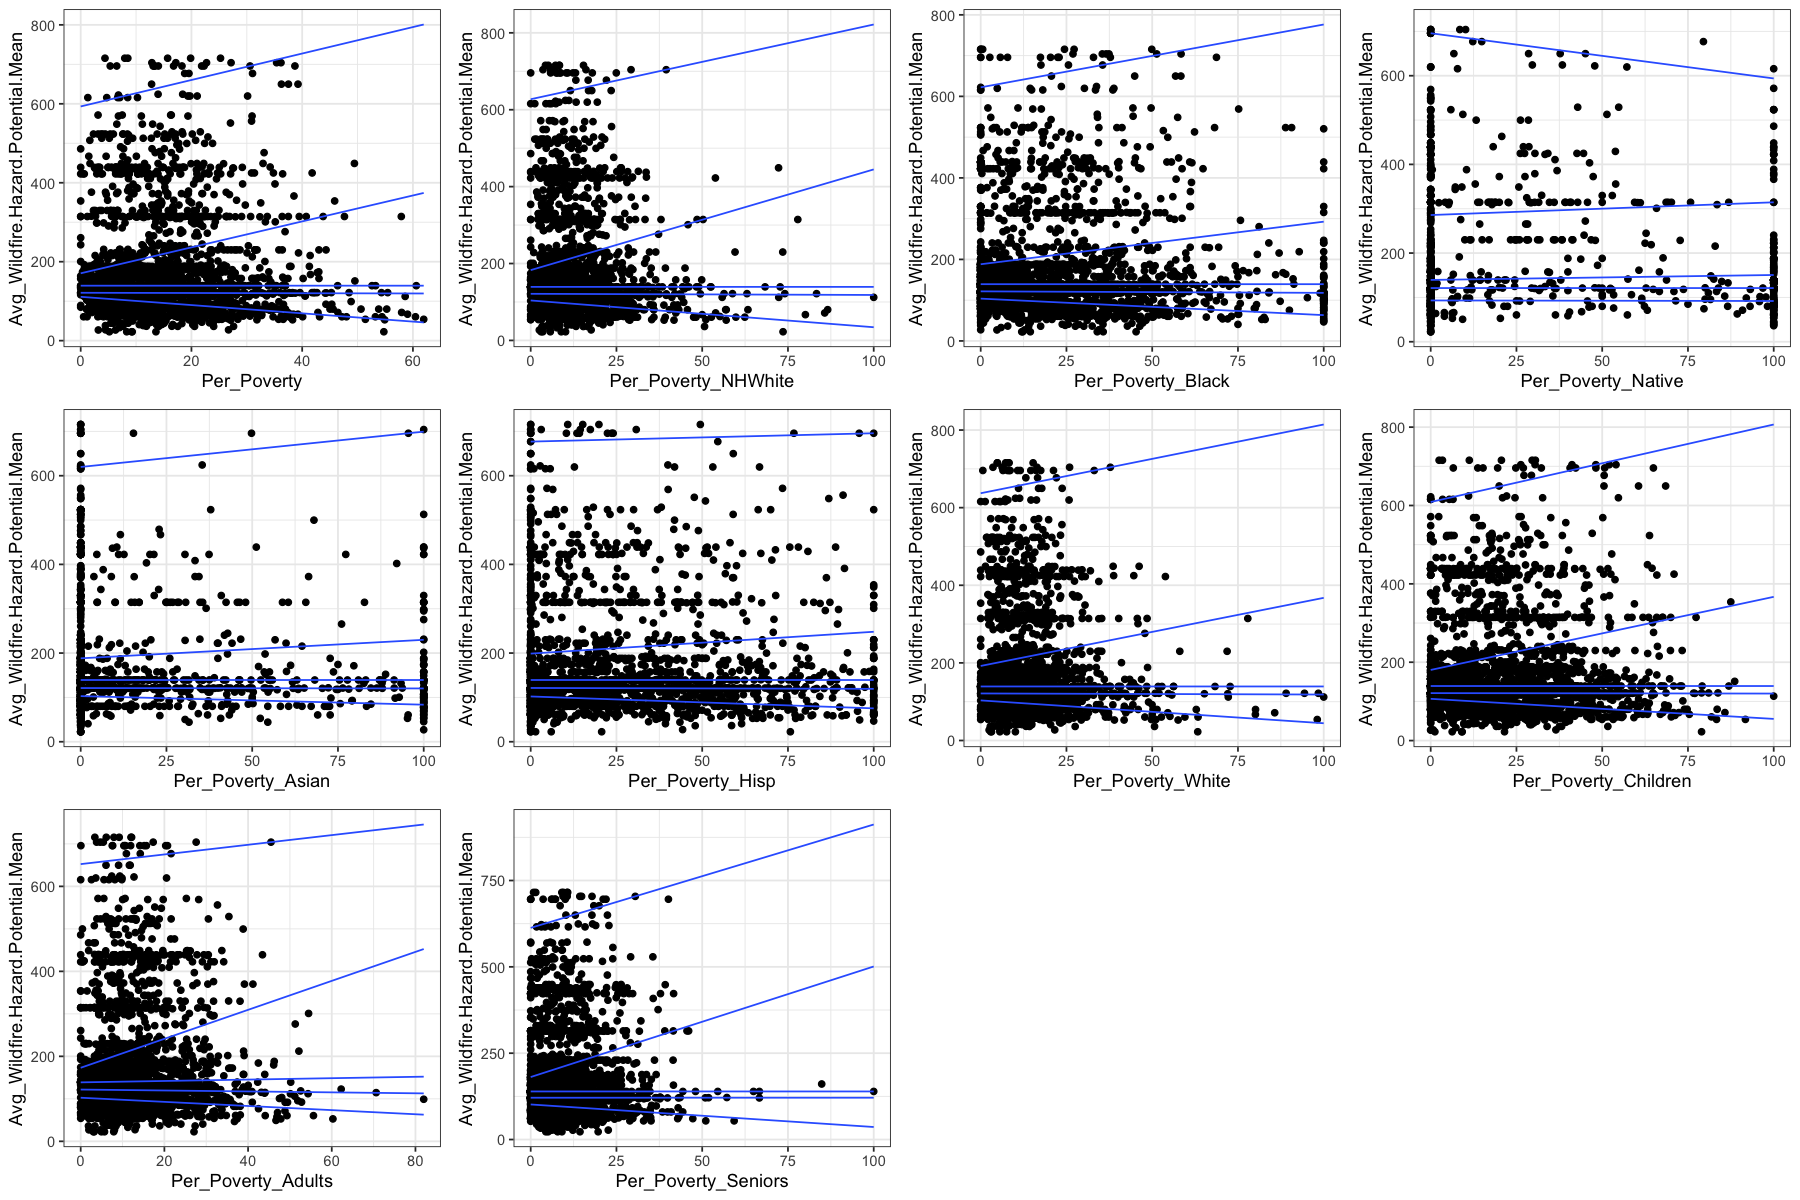

In [14]:
# creating quantile plots
plots = list()
for (i in 1:length(poverty_variables)){
  plots[[i]] = ggplot(data = wildfire_hazard_acs_geometry_df, 
                      mapping = aes_string(x = poverty_variables[i], y = "Avg_Wildfire.Hazard.Potential.Mean")) + 
    geom_point() + 
    geom_quantile(quantiles = c(0.2, 0.4, 0.6, 0.8, 0.99), method = "rq") + 
    theme_bw()
}

# viewing all plots
ggarrange(plotlist = plots)

If we like these quantile regression plots, it would be nice to change the color of those that are significant!